# Random Forrest model for Viral decontamination


## Import Modules

In [1]:

import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
import os
import pandas as pd 
import numpy as np
import sys
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
print('joblib',joblib.__version__)
print('numpy',np.__version__)
print('pandas',pd.__version__)
print('sklearn',sk.__version__)


joblib 1.0.1
numpy 1.19.2
pandas 1.1.3
sklearn 0.24.1


## Load Functions
These inclide functions for annotating  VAMB bin as either Bacterial (based on CheckM) or Viral based on the paired Metaviromes. 

In [11]:
sys.path.append('../repos/phamb/viral_decon/')
import training_functions

## Load Datasets

Load Diabimmune for Evaluation

In [12]:
### Diabimmune

vamb_bins_file = '../diabimu_t1d/04_annotation/annotation_summaries_new/vambbins_aggregated_annotation.txt'
clusters_file = '../diabimu_t1d/05_binning/vamb_on_jgi_v3/clusters.tsv'
MGX_MVX_blast = '../diabimu_t1d/06_blast_MGXMVX/MGX.2000.combined.diabimmune_viral_contigs.m6'
checkm_file ='../diabimu_t1d/07_binannotation/bacteria/checkm/Diabimmune.output'
diab_vambbins_df, diab_vambbins_df_subset,MVX_genome_df,diab_train_object = training_functions.prepare_train_test_set(vamb_bins_file,clusters_file, MGX_MVX_blast,checkm_file)


Reading in Clusters, this may take a while...


/Users/zlf929/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/zlf929/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
diab_vambbins_df_subset.head()

,binid,binsize,nhallm,nVOGs,cluster_DVF_score,LABEL
1,G45060_2,2010035,95,0.57,0.02,Bacterial
3,G45228_3,1715654,88,0.22,0.07,Bacterial
4,G45266_3,1035311,88,0.21,0.07,Bacterial
5,G45229_3,882877,88,0.20,0.07,Bacterial
6,G45106_3,681612,88,0.21,0.07,Bacterial


How well are some MVX genomes covered by MGX contigs. We count the number of MVX genomes by sequence coverage
- LQ = >25% 
- MQ = >50% 
- NC = >90%

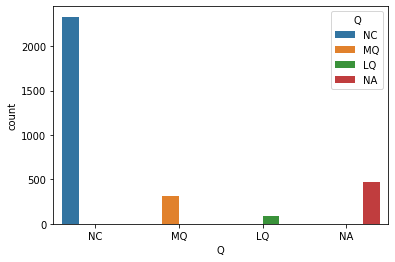

In [14]:
ax = sns.countplot(x="Q", hue="Q", data=MVX_genome_df)

Remove all bins without a Label, preserving all Bins with a Bacterial or Viral Label.

In [16]:
diab_vambbins_df = diab_vambbins_df[ diab_vambbins_df['LABEL'] != 'NA' ] 
evaluation_labels = np.array(diab_vambbins_df['LABEL'])
diab_subset =  diab_vambbins_df[['binsize','nhallm','nVOGs','cluster_DVF_score']]

Distribution of Bacterial hallmark genes in bins labelled either Viral or Bacterial 

<AxesSubplot:xlabel='LABEL', ylabel='nhallm'>

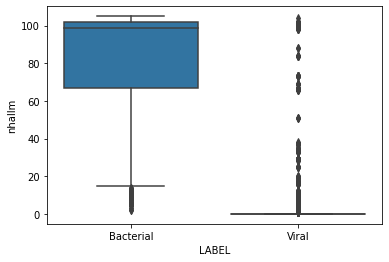

In [17]:
sns.boxplot(x="LABEL",y="nhallm",data=diab_vambbins_df)

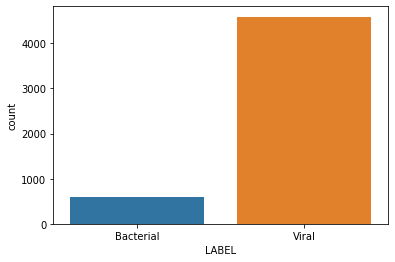

In [15]:
ax = sns.countplot(x="LABEL", data=diab_vambbins_df)

In [10]:
diab_vambbins_df.head()

,binid,ncontigs,binsize,motherbin,nhallm,nVOGs,IMGVRhits_frac,bin_DVF_score,cluster_DVF_score,LABEL
3,G45228_3,556,1715654,3,88,0.22,0.0,0.10,0.07,Bacterial
4,G45266_3,369,1035311,3,88,0.21,0.0,0.09,0.07,Bacterial
5,G45229_3,323,882877,3,88,0.20,0.0,0.07,0.07,Bacterial
15,G45051_3,1,2614,3,88,0.00,0.0,0.86,0.07,Viral
18,G45263_5,263,732338,5,70,0.28,0.0,0.00,0.00,Bacterial


# Load initial COPSAC training and test set

In [18]:
vamb_bins_file = '../COPSAC/04_annotation/annotation_summaries/vambbins_aggregated_annotation.txt'
clusters_file = '../COPSAC/05_binning/vamb_on_jgi/COPSAC/clusters.tsv'
MGX_MVX_blast = '../COPSAC/06_blast_MGXMVX/MGX.2000.copsac.assemblies.vOTUs.selected.m6'
checkm_file ='../COPSAC/07_binannotation/bacteria/checkm/COPSAC.output'

In [19]:
vambbins_df, copsac, MVX_genome_df, copsac_train_objects = training_functions.prepare_train_test_set(vamb_bins_file,clusters_file, MGX_MVX_blast, checkm_file)

Reading in Clusters, this may take a while...


/Users/zlf929/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/zlf929/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [20]:
copsac_labelled_bins = dict(zip(copsac.binid, copsac.LABEL))
len(copsac_labelled_bins)

61036

## Test how i.e. DVF would perform on Predicting Bacterial and Viral bins using own predictions


Bassically use the labels of each binid to annotate each contig to either Bacterial or Viral using the DVF score (pvalue <0.05 and score > 0.6). 

* Define True Labeel and Prediction Label and get performance. 

In [21]:
clusters_file = '../COPSAC/05_binning/vamb_on_jgi/COPSAC/clusters.tsv'
DVF_predictions_file='../COPSAC/04_annotation/annotation_summaries/DVFpredictions.allsamples.txt'
dvf_table = training_functions.return_DVF_table(clusters_file, DVF_predictions_file, copsac_labelled_bins)

Reading in Clusters, this may take a while...


In [22]:
dvf_table.head()

,contigid,binid,LABEL,DVF_prediction,DVF_score
0,18097D-02-01_NODE_14_length_344806_cov_33.0967...,18097D-02-01_605,Bacterial,Viral,0.7350640892982483
1,18097D-02-01_NODE_1_length_540752_cov_207.0461...,18097D-02-01_2368,Bacterial,Viral,0.816938042640686
2,18097D-02-01_NODE_15_length_330305_cov_191.714...,18097D-02-01_2368,Bacterial,Viral,0.7505811452865601
3,18097D-02-01_NODE_2_length_533468_cov_31.00501...,18097D-02-01_605,Bacterial,Viral,0.9422299265861511
4,18097D-02-01_NODE_16_length_328445_cov_176.221...,18097D-02-01_2368,Bacterial,Viral,0.8186649084091187


### Evaluate DVF performance 

In [23]:
copsac_labels = list(dvf_table.LABEL)

DVF_prediction = list(dvf_table.DVF_prediction)
DVF_score = [ float(i) for i in dvf_table.DVF_score ] 
 
def get_DVF_tprfrp(evaluation_labels,DVF_score):

    evaluation_labels = np.where(np.array(evaluation_labels) == 'Bacterial',0,1)
    fpr, tpr, thresh = metrics.roc_curve(evaluation_labels, DVF_score)
    auc = metrics.auc(fpr, tpr)
    return fpr,tpr, auc   


DVF_eval_results = {}
DVF_eval_results['recall'] = recall_score(copsac_labels, DVF_prediction,average='macro')
DVF_eval_results['precision'] = precision_score(copsac_labels, DVF_prediction,average='macro')
DVF_eval_results['roc'] = roc_auc_score(copsac_labels, DVF_score,average='macro')

DVF_eval_results['MCC'] = matthews_corrcoef(copsac_labels,DVF_prediction)

fpr, tpr, auc = get_DVF_tprfrp(copsac_labels, np.array(DVF_score))

DVF_eval_results['fpr'] = fpr
DVF_eval_results['tpr'] = tpr
DVF_eval_results['auc'] = auc

### 
confusion_matrix(copsac_labels, DVF_prediction)

array([[1240076,  206475],
       [  22232,   49926]])

In [24]:
print(DVF_eval_results)

{'recall': 0.7745811337627604, 'precision': 0.5885531229689516, 'roc': 0.8509973937989439, 'MCC': 0.3118654639619325, 'fpr': array([0.00000000e+00, 7.25864487e-05, 7.94994438e-05, ...,
       9.98954755e-01, 9.98954755e-01, 1.00000000e+00]), 'tpr': array([0.        , 0.01139167, 0.01214003, ..., 0.99998614, 1.        ,
       1.        ]), 'auc': 0.8509973937989439}


# Load the expanded COPSAC dataset

Also read in the large COPSAC viral genome evaluation set

In [25]:
vamb_bins_file = '../COPSAC/04_annotation/annotation_summaries/vambbins_aggregated_annotation.txt'
clusters_file = '../COPSAC/05_binning/vamb_on_jgi/COPSAC/clusters.tsv'
MGX_MVX_blast = '../COPSAC/06_blast_MGXMVX/MGX.2000.copsac.assemblies.vOTUs.new.m6'
checkm_file ='../COPSAC/07_binannotation/bacteria/checkm/COPSAC.output'

In [26]:
copsac_eval_vambbins_df, copsac_eval ,copsac_eval_MVX_genome_df, train_object = training_functions.prepare_train_test_set(vamb_bins_file,clusters_file, MGX_MVX_blast, checkm_file)





Reading in Clusters, this may take a while...


/Users/zlf929/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/zlf929/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


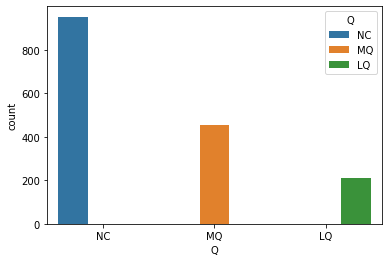

In [27]:
nMVX_otu = len(MVX_genome_df.index)
ax = sns.countplot(x="Q", hue="Q", data=MVX_genome_df[MVX_genome_df['Q']!='NA'])

<AxesSubplot:xlabel='LABEL', ylabel='count'>

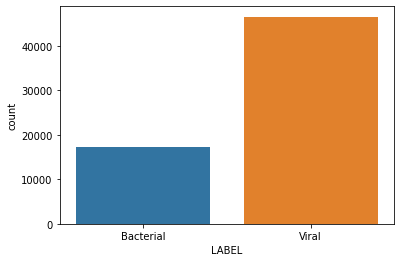

In [31]:
sns.countplot(x="LABEL", data=copsac_eval)

<AxesSubplot:xlabel='LABEL', ylabel='nhallm'>

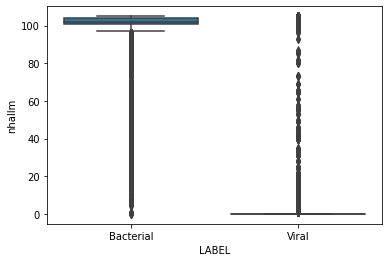

In [32]:
sns.boxplot(x="LABEL",y="nhallm",data=copsac_eval)


# Train Model using COPSAC the initial metavirome


In [53]:
# 60% of Data for the test
### Make super basic RF model
train = copsac_train_objects['train']
test  = copsac_train_objects['test']
train_labels = copsac_train_objects['train_labels']
test_labels = copsac_train_objects['test_labels']
print(len(train))
print(len(test))
test

24414
36622


,binid,binsize,nhallm,nVOGs,cluster_DVF_score,LABEL
225319,18097D-02-274_68895,3049,0,1.00,0.55,Viral
153424,18097D-02-315_14044,2636,0,1.00,0.56,Viral
82025,18097D-02-336_3452,4025,0,1.00,1.00,Viral
6890,18097D-02-247_367,2875,101,0.00,0.00,Bacterial
58741,18097D-02-162_2228,118269,0,1.00,1.00,Viral
...,...,...,...,...,...,...
171614,18097D-02-295_20933,52513,0,2.50,0.99,Viral
228877,18097D-02-177_73932,3449,0,4.00,0.97,Viral
229017,18097D-02-216_74124,47550,0,16.00,0.86,Viral
206087,18097D-02-315_45739,2851,0,1.00,0.89,Viral


In [55]:
train_binids = list(train.binid)
train = train[['binsize','nhallm','nVOGs','cluster_DVF_score']]
test_binids = list(test.binid)
test = test[['binsize','nhallm','nVOGs','cluster_DVF_score']]


AttributeError: 'DataFrame' object has no attribute 'binid'

### Train default random Forrest model

In [46]:

default_model = RandomForestClassifier(n_estimators=300, 
                            random_state=1, 
                            max_features = 'sqrt',
                            n_jobs=1, verbose = 1)


bin_test_labels = np.where(np.array(test_labels) == 'Bacterial',0,1)
bin_train_labels = np.where(np.array(train_labels) == 'Bacterial',0,1)

train.head()
test.head()


### Trained default model
trained_default_model = default_model.fit(np.array(train), np.array(bin_train_labels))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    2.2s finished


### Identify the best Forrest model using random search with 3 fold cross validation

In [41]:
best_random_model = training_functions.randomsearch_crossval(train, train_labels)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=267; total time=   2.0s


[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=267; total time=   1.8s


[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=267; total time=   2.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.1s


[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=267; total time=   2.0s


[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=267; total time=   1.8s


[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=267; total time=   1.9s


[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=293; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=293; total time=   2.1s


[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=293; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=371; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=371; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=371; total time=   2.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   1.1s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   1.2s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   1.2s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=164; total time=   1.1s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=164; total time=   1.0s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=164; total time=   1.1s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=164; total time=   1.5s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=164; total time=   1.2s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=164; total time=   1.2s


[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=474; total time=   3.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=474; total time=   3.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=474; total time=   3.4s


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=61; total time=   0.5s


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=61; total time=   0.5s


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=61; total time=   0.4s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=138; total time=   0.7s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=138; total time=   0.7s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=242; total time=   1.3s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=242; total time=   1.3s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=242; total time=   1.3s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=242; total time=   1.7s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=242; total time=   1.8s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=242; total time=   1.8s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=293; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=293; total time=   2.1s


[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=293; total time=   2.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=293; total time=   2.2s


[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=293; total time=   2.2s


[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 293 out of 293 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=293; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.1s


[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=113; total time=   0.6s


[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=113; total time=   0.6s


[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=113; total time=   0.6s


[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=396; total time=   2.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=396; total time=   2.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=396; total time=   2.9s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=422; total time=   3.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=422; total time=   2.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=422; total time=   3.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=474; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=474; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=474; total time=   2.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=242; total time=   1.7s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=242; total time=   1.7s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=242; total time=   1.8s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=190; total time=   1.0s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=190; total time=   1.1s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=190; total time=   1.1s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=190; total time=   1.2s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=190; total time=   1.0s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=190; total time=   1.1s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242; total time=   1.3s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242; total time=   1.3s


[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 242 out of 242 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242; total time=   1.3s


[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=371; total time=   2.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=371; total time=   2.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=371; total time=   2.1s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=474; total time=   3.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=474; total time=   3.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 474 out of 474 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=474; total time=   4.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=   3.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=371; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=371; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 371 out of 371 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=371; total time=   2.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=190; total time=   1.1s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=190; total time=   1.0s


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=190; total time=   1.1s


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=216; total time=   1.2s


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=216; total time=   1.2s


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=216; total time=   1.2s


[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=422; total time=   2.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=422; total time=   2.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 422 out of 422 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=422; total time=   2.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=267; total time=   1.5s


[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=267; total time=   1.4s


[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 267 out of 267 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=267; total time=   1.5s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=345; total time=   2.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=345; total time=   2.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=345; total time=   2.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=345; total time=   2.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=345; total time=   2.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=345; total time=   2.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=345; total time=   2.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=345; total time=   2.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=345; total time=   2.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=319; total time=   1.7s


[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=319; total time=   1.7s


[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=319; total time=   1.8s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35; total time=   0.3s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35; total time=   0.3s


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=35; total time=   0.3s


[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=396; total time=   2.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=396; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=396; total time=   2.9s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=164; total time=   1.2s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=164; total time=   1.1s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=164; total time=   1.2s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   3.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=396; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=396; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=396; total time=   2.2s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.2s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.1s


[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=164; total time=   1.2s


[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=319; total time=   1.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=319; total time=   1.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 319 out of 319 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=319; total time=   1.8s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   0.7s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   0.7s


[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=138; total time=   0.8s


[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=87; total time=   0.5s


[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=87; total time=   0.5s


[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=87; total time=   0.5s


[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=396; total time=   2.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=396; total time=   2.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 396 out of 396 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=396; total time=   2.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s
{'n_estimators': 61, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.6s finished


### Identify the best Forrest model using grid search with 3 fold cross validation

In [43]:
best_grid_model = training_functions.gridsearch_crossval(train, train_labels)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   2.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   2.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   1.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   2.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   2.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   1.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   2.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   2.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=345; total time=   1.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.6s finished


In [60]:

best_random_model.fit(np.array(train), np.array(bin_train_labels))
predictions = np.array(best_random_model.predict(np.array(test)),dtype='int64')

eval_results = {}
eval_results['recall'] = recall_score(bin_test_labels, predictions,average='macro')
eval_results['precision'] = precision_score(bin_test_labels, predictions,average='macro')
eval_results['roc'] = roc_auc_score(bin_test_labels, predictions,average='macro')

### 
print(confusion_matrix(bin_test_labels,predictions))
print(eval_results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[10403    18]
 [   26 26175]]
{'recall': 0.9986401950060024, 'precision': 0.9984098726317753, 'roc': 0.9986401950060025}


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.1s finished


In [61]:

best_grid_model.fit(np.array(train), np.array(bin_train_labels))
predictions = np.array(best_grid_model.predict(np.array(test)),dtype='int64')

print(predictions)

eval_results = {}
eval_results['recall'] = recall_score(bin_test_labels, predictions,average='macro')
eval_results['precision'] = precision_score(bin_test_labels, predictions,average='macro')
eval_results['roc'] = roc_auc_score(bin_test_labels, predictions,average='macro')

### 
print(confusion_matrix(bin_test_labels,predictions))
print(eval_results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[1 1 1 ... 1 1 0]
[[10404    17]
 [   28 26173]]
{'recall': 0.9986500085641103, 'precision': 0.9983334241046435, 'roc': 0.9986500085641102}


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.4s finished


In [63]:
predictions = np.array(trained_default_model.predict(np.array(test)),dtype='int64')

eval_results = {}
eval_results['recall'] = recall_score(bin_test_labels, predictions,average='macro')
eval_results['precision'] = precision_score(bin_test_labels, predictions,average='macro')
eval_results['roc'] = roc_auc_score(bin_test_labels, predictions,average='macro')

### 
print(confusion_matrix(bin_test_labels,predictions))
print(eval_results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[10404    17]
 [   28 26173]]
{'recall': 0.9986500085641103, 'precision': 0.9983334241046435, 'roc': 0.9986500085641102}


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


What are the most important features for predicting the right bins?

<AxesSubplot:>

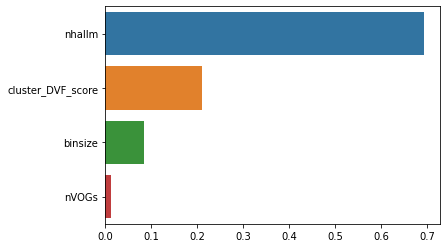

In [62]:
feature_imp = pd.Series(best_grid_model.feature_importances_ , index=list(train.columns)).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

## Evaluate Performance on COPSAC extra Viral genomes
Basically we test our trained Random Forest model on all the extra bins corresponding to the expanded COPSAC Metavirome assemblies


In [64]:
### Extra Viral Genomes - Subset so we do not predict on those used for Training the RF model
copsac_eval_labels = np.array(copsac_eval['LABEL'])
train_mask = np.array( [ x not in train_binids for x in list(copsac_eval.binid)])

copsac_eval_subset = copsac_eval[train_mask]
copsac_eval_subset = copsac_eval[['binsize','nhallm','nVOGs','cluster_DVF_score']]


In [65]:

 
def get_tprfrp(evaluation_labels,DVF_score):

    fpr, tpr, thresh = metrics.roc_curve(evaluation_labels, DVF_score)
    auc = metrics.auc(fpr, tpr)
    return fpr,tpr, auc   


eval_predictions = trained_default_model.predict(copsac_eval_subset)
eval_probs = trained_default_model.predict_proba(copsac_eval_subset)[:, 1]

binary_copsac_eval_labels = np.where(np.array(copsac_eval_labels) == 'Bacterial',0,1)
#binary_copsac_eval_labels = np.array([labs[x] for x in copsac_eval_labels])

print(f'Evaluation ROC AUC Score: {roc_auc_score(copsac_eval_labels, eval_probs)}')



eval_results = {}
eval_results['recall'] = recall_score(binary_copsac_eval_labels, eval_predictions,average='macro')
eval_results['precision'] = precision_score(binary_copsac_eval_labels, eval_predictions,average='macro')
eval_results['roc'] = roc_auc_score(binary_copsac_eval_labels, eval_probs,average='macro')

eval_results['MCC'] = matthews_corrcoef(binary_copsac_eval_labels,eval_predictions)
#eval_results['F1'] = f1_score(copsac_labels,DVF_prediction)

fpr, tpr, auc = get_tprfrp(binary_copsac_eval_labels, eval_probs)

eval_results['fpr'] = fpr
eval_results['tpr'] = tpr
eval_results['auc'] = auc

### 
confusion_matrix(binary_copsac_eval_labels,eval_predictions)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished


Evaluation ROC AUC Score: 0.9992249651055206


array([[17245,    12],
       [  146, 46415]])

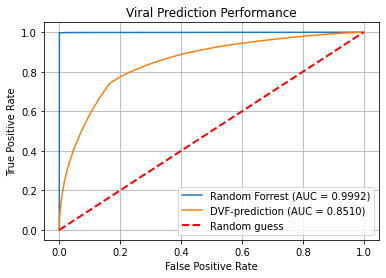

In [67]:
plt.plot(eval_results['fpr'], eval_results['tpr'], label='Random Forrest (AUC = %.4f)' %eval_results['auc'])
plt.plot(DVF_eval_results['fpr'], DVF_eval_results['tpr'], label='DVF-prediction (AUC = %.4f)' %DVF_eval_results['auc'])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('Viral Prediction Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.savefig('/Users/zlf929/Dropbox/phamb/Figures/RF_viral_roc.pdf')
plt.show()


## Evaluate Performance on Diabimmune


In [68]:
print(diab_vambbins_df_subset.shape)

diab_vambbins_df_subset.head()
diab_subset = diab_vambbins_df_subset[['binsize','nhallm','nVOGs','cluster_DVF_score']]
diab_subset.shape

(24241, 6)


(24241, 4)

In [73]:
import pandas as pd
def evaluate_on_testset(m,modelname,diab_subset,evaluation_labels):
    
    ### Evaluate on Diabimmune Test-set
    predictions = np.array(m.predict(np.array(diab_subset)),dtype='int64')
    probabilities = m.predict_proba(diab_subset)[:, 1]

    evaluation_labels = np.where(evaluation_labels == 'Bacterial',0,1)

    eval_results = {}
    eval_results['name'] = modelname
    eval_results['roc_auc_score'] = roc_auc_score(evaluation_labels, probabilities)
    eval_results['recall'] = recall_score(evaluation_labels, predictions,average='macro')
    eval_results['precision'] = precision_score(evaluation_labels, predictions,average='macro')
    eval_results['MCC'] = matthews_corrcoef(evaluation_labels,predictions)
    eval_results['F1'] = f1_score(evaluation_labels,predictions)
    tmp = [eval_results['name'], eval_results['roc_auc_score'],eval_results['recall'], 
           eval_results['precision'], eval_results['MCC'],eval_results['F1'] ]
    print(confusion_matrix(evaluation_labels,predictions))
    return tmp
    
model_dict = {'default_rf': trained_default_model, 'best_random_model':best_random_model,'best_grid_model':best_grid_model}
#model_dict = {'default_rf': trained_default_model}
evaluation_diabimmune = []

evaluation_labels = diab_vambbins_df_subset[['LABEL']]

for m in model_dict:
    res = evaluate_on_testset(model_dict[m], m,diab_subset, evaluation_labels)
    evaluation_diabimmune.append(res)

evaluation_diabimmune_df = pd.DataFrame(evaluation_diabimmune,columns=['name','auc','recall','precision','MCC','F1'])
    
evaluation_extra_copsac = []  
for m in model_dict:
    res = evaluate_on_testset(model_dict[m],  m,copsac_eval_subset, copsac_eval_labels)
    evaluation_extra_copsac.append(res)
evaluation_extra_copsac = pd.DataFrame(evaluation_extra_copsac,columns=['name','auc','recall','precision','MCC','F1'])

    
    
### Get DVF predictions , >= 0.75 -> 1 
#DVF_predictions = np.where(diab_vambbins_df.bin_DVF_score >= 0.5,1,0)
#DVF_probs = np.array(diab_vambbins_df.bin_DVF_score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[ 1908     7]
 [   85 22241]]
[[ 1905    10]
 [   82 22244]]


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[ 1907     8]
 [   85 22241]]


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[17245    12]
 [  146 46415]]


[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.1s finished


[[17244    13]
 [  145 46416]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[17245    12]
 [  146 46415]]


[Parallel(n_jobs=1)]: Done 345 out of 345 | elapsed:    0.7s finished


In [74]:
evaluation_diabimmune_df


,name,auc,recall,precision,MCC,F1
0,default_rf,0.998806,0.996269,0.978518,0.974625,0.997936
1,best_random_model,0.998589,0.995553,0.979141,0.974556,0.997936
2,best_grid_model,0.998899,0.996008,0.978485,0.974335,0.997914


In [71]:

def get_tprfrp(m , diab_subset, evaluation_labels):
    probabilities = m.predict_proba(diab_subset)[:, 1]
    evaluation_labels = np.where(evaluation_labels == 'Bacterial',0,1)
    fpr, tpr, thresh = metrics.roc_curve(evaluation_labels, probabilities)
    auc = metrics.auc(fpr, tpr)
    return fpr,tpr, auc
    

fpr,tpr, auc = get_tprfrp(trained_default_model,diab_subset,evaluation_labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.3s finished


# Save optimised RF model 


In [276]:
filename = 'RF_model.sav'
joblib.dump(trained_model, filename)
 
# some time later...

print(sklearn.__version__)

NameError: name 'sklearn' is not defined

In [ ]:
 
# load the model from disk
loaded_model = joblib.load('RF_model.sav')


# Predict Viral Bins in HMP2

In [238]:
vamb_bins_file = '../HMP2/04_annotation/annotation_summaries/vambbins_aggregated_annotation.txt'

HMP2_vambbins = pd.read_csv(vamb_bins_file,sep='\t')


In [285]:
HMP2_vambbins.head()
trained_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=1, verbose=1, warm_start=False)

In [240]:
HMP2_subset = HMP2_vambbins[['binsize','nhallm','nVOGs','cluster_DVF_score']]
eval_predictions = trained_default_model.predict(HMP2_subset)
eval_probs = trained_default_model.predict_proba(HMP2_subset)[:, 1]



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   20.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   20.9s finished


In [246]:
eval_predictions = np.where(eval_predictions == 0,'Bacterial','Viral')

In [260]:
HMP2_vambbins['Prediction'] = eval_predictions
HMP2_vambbins['Probability'] = eval_probs
HMP2_vambbins['scaled_nVOG'] = HMP2_vambbins.nVOGs/HMP2_vambbins.binsize

In [251]:
HMP2_vambbins_filtered = HMP2_vambbins[ (HMP2_vambbins.Prediction =='Viral') & (HMP2_vambbins.nVOGs >= 1) & (HMP2_vambbins.cluster_DVF_score >= 0.3) ]

In [254]:
HMP2_vambbins.head()

,binid,ncontigs,binsize,motherbin,nhallm,nVOGs,IMGVRhits_frac,bin_DVF_score,cluster_DVF_score,Prediction,Probability
0,CSM7KOOL_1,1,2505,1,0,0.00,0.0,0.06,0.06,Viral,1.0
1,MSM79H9Q_2,1,3669,2,0,3.00,0.0,0.45,0.45,Viral,1.0
2,MSM79HB6_3,331,1269034,3,102,0.39,0.0,0.06,0.37,Bacterial,0.0
3,PSM7J1DF_3,141,397230,3,102,0.32,0.0,0.04,0.37,Bacterial,0.0
4,HSMA33J9_3,157,441585,3,102,0.29,0.0,0.03,0.37,Bacterial,0.0


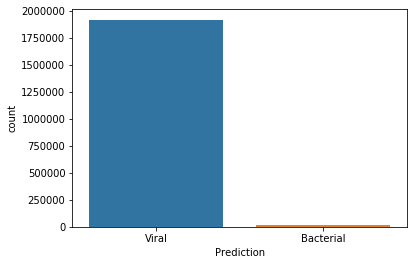

In [252]:
sns.countplot("Prediction",data=HMP2_vambbins)

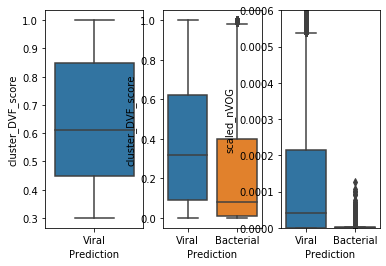

In [263]:

fig, (ax1, ax2, ax3) = pyplot.subplots(ncols=3, sharey=False)
sns.boxplot(x="Prediction",y="cluster_DVF_score",data=HMP2_vambbins_filtered, ax=ax1)
sns.boxplot(x="Prediction",y="cluster_DVF_score",data=HMP2_vambbins, ax=ax2)
ax3.set(ylim=(0,0.0006))
sns.boxplot(x="Prediction",y="scaled_nVOG",data=HMP2_vambbins, ax=ax3)

In [264]:
sum(HMP2_vambbins_filtered.ncontigs)
print(HMP2_vambbins_filtered.shape)

(500226, 11)
